In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
# Set device (Use GPU or MPS if available)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
batch_size = 10
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [4]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [5]:
cifar10_dir = 'kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py'
test_data_dir = 'kaggle/input/DLProj1/cifar_test_nolabel.pkl'

In [6]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

In [7]:
class CIFARDataset(Dataset):
    def __init__(self, image_list, label_list=None, transform=None):
        """
        image_list: List of NumPy arrays of shape (10000, 32, 32, 3)
        label_list: Single list of 50000 labels
        transform: Transformations to apply to each image
        """
        self.images = image_list if label_list is None else np.concatenate(image_list, axis=0)
        self.labels = np.array(label_list) if label_list is not None else None  # Convert labels to NumPy array
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # Convert NumPy image to PIL (transform expects PIL image)
        image = torch.tensor(image, dtype=torch.uint8).permute(2, 0, 1)  # Convert to (C, H, W) format
        toPILImage = tt.ToPILImage()
        image = toPILImage(image)  # Convert to PIL image

        if self.transform:
            image = self.transform(image)  # Apply transforms
        if self.labels is not None:
            label = self.labels[idx]
            return image, torch.tensor(label, dtype=torch.long)
        else:
            return image

In [8]:
def getDataLoaders(train_data_dir, test_pkl_dir, batch_size_in):
    train_data = []
    train_labels = []
    for i in range(1, 6):  # CIFAR-10 has 5 training batches
        batch_dict = load_cifar_batch(os.path.join(train_data_dir, f'data_batch_{i}'))
        image_data = batch_dict[b'data']
        train_labels_batch = batch_dict[b'labels']
        train_images = image_data.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)  # N x W x H x C format
        train_data.append(train_images)
        train_labels.extend(train_labels_batch)

    pin_Mem = device.type == "cuda"
    # Get Train Images Data:
    train_dataset = CIFARDataset(train_data, train_labels, transform=train_tfms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size_in, shuffle=True, pin_memory=pin_Mem)
    
    # Get Test Images data
    test_batch = load_cifar_batch(test_pkl_dir)
    test_images = test_batch[b'data']  # Already in N x W x H x C format
    
    test_dataset = CIFARDataset(test_images, label_list=None, transform=valid_tfms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_in, shuffle=False, pin_memory=pin_Mem)
    return train_loader, test_loader

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=(device.type=="cuda"))


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [9]:
train_loader, test_loader = getDataLoaders(cifar10_dir, test_data_dir, batch_size)
train_dl = DeviceDataLoader(train_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

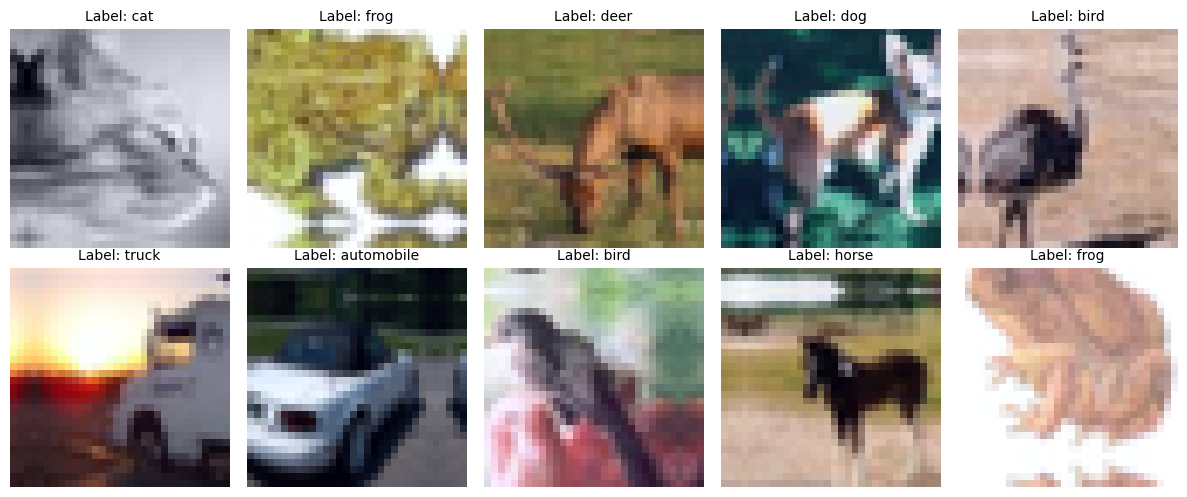

In [10]:
# Code below to test if dataloader is working properly:
# CIFAR-10 class names
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

images, labels = next(iter(train_dl))
images, labels = images[:10].cpu(), labels[:10].cpu()  # Take first 10 images if batch size at least 10

fig, axes = plt.subplots(2, 5, figsize=(12, 5))  # 2 rows, 5 columns

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0)  # Convert (C, H, W) → (H, W, C)
    img = img * 0.2023 + 0.4914  # Simple normalization adjustment (approximation)
    
    ax.imshow(img.clamp(0, 1))  # Clamp values between 0 and 1
    ax.set_title(f"Label: {cifar10_classes[labels[i]]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc

    def validation_step(self, batch):
        # images, labels = batch
        images = batch
        out = self(images)  # Generate predictions
        # loss = F.cross_entropy(out, labels)  # Calculate loss
        loss = None
        # acc = accuracy(out, labels)  # Calculate accuracy
        acc = None
        # return {'val_loss': loss.detach(), 'val_acc': acc}
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {}, train_acc: {} val_loss: {}, val_acc: {}".format(
            epoch, result['lrs'][-1], result['train_loss'],result['train_acc'], result['val_loss'], result['val_acc']))


In [13]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [14]:
class ResNet_v1(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 224, pool=True)
        self.conv4 = conv_block(224, 416, pool=True)
        self.res2 = nn.Sequential(conv_block(416, 416), conv_block(416, 416))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(416, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [15]:
@torch.no_grad()
def evaluate(model, val_loader, has_labels=True):
    model.eval()
    outputs = []
    for batch in val_loader:
        outputs.append(model.validation_step(batch))  # Regular validation

    return model.validation_epoch_end(outputs)

In [16]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [17]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):    
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accs = []
        lrs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        # result = evaluate(model, val_loader, has_labels=False)
        result = {'val_loss':None, 'val_acc':None}
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
model = to_device(ResNet_v1(3, 10), device)
print(f"Total Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Total Trainable Parameters: 4,592,010
Total number of parameters: 4592010


In [19]:
# history = [evaluate(model, test_dl, has_labels=False)]
history = []
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 1.635185956954956, train_acc: 0.4449400305747986 val_loss: None, val_acc: None


KeyboardInterrupt: 